<a href="https://colab.research.google.com/github/jayasuryajsk/quarantine-time-pass/blob/master/Image-Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision  import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_label = path/'labels'
path_image = path/'images'

In [0]:
fnames = get_image_files(path_image)
lnames = get_image_files(path_label)

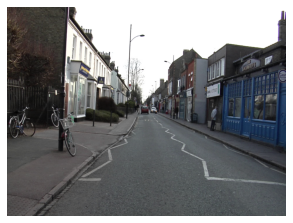

In [5]:
image_f = fnames[0]
img = open_image(image_f)
img.show(figsize=(5,5))

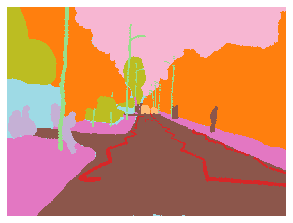

In [6]:
get_y_fn = lambda x: path_label/f'{x.stem}_P{x.suffix}'
mask = open_mask(get_y_fn(image_f))
mask.show(figsize=(5,5), alpha=1)

In [7]:
src_size = np.array(mask.shape[1:])
src_size,mask.data


(array([720, 960]), tensor([[[26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str);
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [9]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_image)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

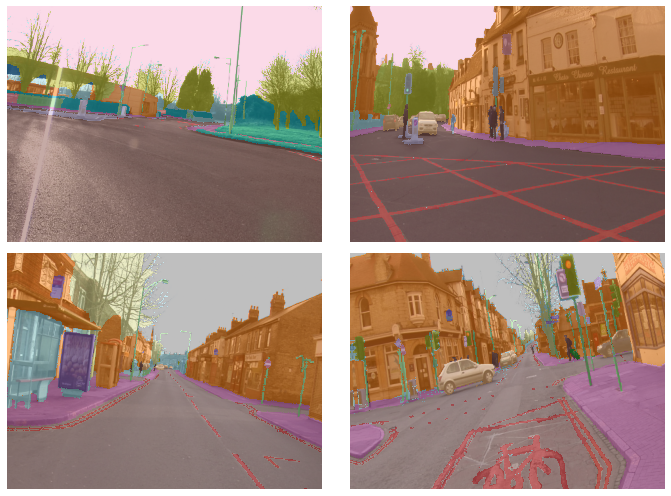

In [12]:
data.show_batch(2, figsize=(10,7))

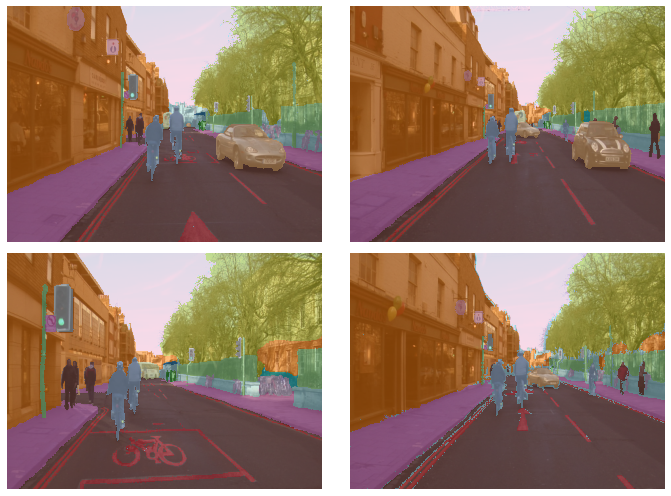

In [13]:

data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [15]:
metrics=acc_camvid
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


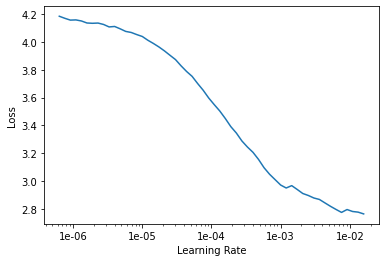

In [16]:
lr_find(learn)
learn.recorder.plot()

In [17]:
lr=3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.965527,0.711386,0.817946,01:43
1,0.713355,0.525109,0.856824,01:41
2,0.674596,0.539789,0.856098,01:41
3,0.641101,0.453154,0.872447,01:40
4,0.595486,0.484197,0.868030,01:39
5,0.609689,0.503050,0.869040,01:39
6,0.570793,0.435040,0.878424,01:38
7,0.538593,0.430151,0.883481,01:38
8,0.505203,0.489083,0.862155,01:38
9,0.422498,0.341175,0.898374,01:38


In [0]:
learn.save('stage-1')

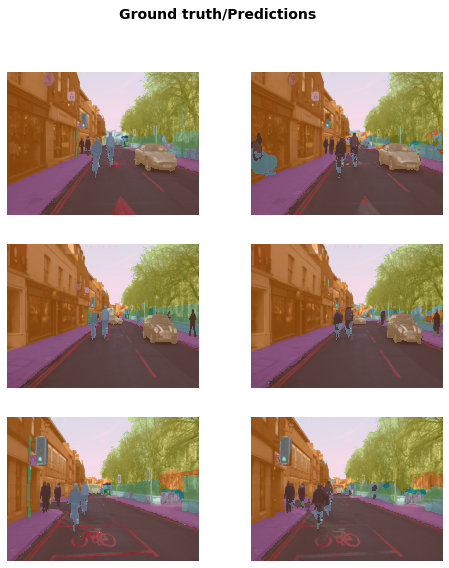

In [19]:
learn.load('stage-1')
learn.show_results(rows=3, figsize=(8,9))

In [20]:
learn.unfreeze()
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.387678,0.326264,0.902502,01:42
1,0.380979,0.321267,0.903091,01:44
2,0.364114,0.321201,0.904053,01:44
3,0.354657,0.306842,0.911004,01:44
4,0.358065,0.318613,0.905806,01:44
5,0.469005,0.454975,0.868446,01:44
6,0.406366,0.337085,0.908279,01:44
7,0.466041,0.409408,0.881407,01:44
8,0.500545,0.717124,0.792286,01:44
9,0.643066,0.670628,0.819809,01:44
